In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv("Data/Copy of hackathon_customerData_challenge2.csv")
df.head()

,customerID,Date_UTC,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21T18:00:00.000Z,2022-10-22,15,4099.0,NaN
1,793,2022-10-21T18:15:00.000Z,2022-10-22,15,5566.0,NaN
2,793,2022-10-21T18:30:00.000Z,2022-10-22,16,3565.5,NaN
3,793,2022-10-21T18:45:00.000Z,2022-10-22,16,3420.5,NaN
4,793,2022-10-21T19:00:00.000Z,2022-10-22,17,3236.5,NaN


In [7]:
# Drop rows where laod power is 0
df = df[df['load_power_W'] != 0.0]

In [63]:
# Convert date column from str to datetime
df['Date_UTC'] = pd.to_datetime(df['Date_UTC'])

In [69]:
df['Date_NZDT'] = df['Date_UTC'] + pd.Timedelta(hours=13)
df.insert(2, 'Date_NZDT', df.pop('Date_NZDT'))
df.head()

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN


In [72]:

customer_793 = df[df.customerID == 793] 
customer_793

,customerID,Date_UTC,Date_NZDT,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
0,793,2022-10-21 18:00:00+00:00,2022-10-22 07:00:00+00:00,2022-10-22,15,4099.0,NaN
1,793,2022-10-21 18:15:00+00:00,2022-10-22 07:15:00+00:00,2022-10-22,15,5566.0,NaN
2,793,2022-10-21 18:30:00+00:00,2022-10-22 07:30:00+00:00,2022-10-22,16,3565.5,NaN
3,793,2022-10-21 18:45:00+00:00,2022-10-22 07:45:00+00:00,2022-10-22,16,3420.5,NaN
4,793,2022-10-21 19:00:00+00:00,2022-10-22 08:00:00+00:00,2022-10-22,17,3236.5,NaN
...,...,...,...,...,...,...,...
4791132,793,2022-10-21 16:45:00+00:00,2022-10-22 05:45:00+00:00,2022-10-22,12,1041.0,NaN
4791133,793,2022-10-21 17:00:00+00:00,2022-10-22 06:00:00+00:00,2022-10-22,13,2617.0,NaN
4791134,793,2022-10-21 17:15:00+00:00,2022-10-22 06:15:00+00:00,2022-10-22,13,3948.0,NaN
4791135,793,2022-10-21 17:30:00+00:00,2022-10-22 06:30:00+00:00,2022-10-22,14,3955.5,NaN


In [65]:
customer_793_on_10_22 = customer_793[customer_793.Date_NZDate != "2022-10-22"]
customer_793_on_10_22

,customerID,Date_UTC,Date_NZDate,date_settlementPeriod,load_power_W,weather_Temp_C
68,793,2022-10-22 11:00:00+00:00,2022-10-23,1,497.5,NaN
69,793,2022-10-22 11:15:00+00:00,2022-10-23,1,349.0,NaN
70,793,2022-10-22 11:30:00+00:00,2022-10-23,2,388.5,NaN
71,793,2022-10-22 11:45:00+00:00,2022-10-23,2,388.0,NaN
72,793,2022-10-22 12:00:00+00:00,2022-10-23,3,368.5,NaN
...,...,...,...,...,...,...
4791104,793,2022-10-21 09:45:00+00:00,2022-10-21,46,985.0,NaN
4791105,793,2022-10-21 10:00:00+00:00,2022-10-21,47,723.0,NaN
4791106,793,2022-10-21 10:15:00+00:00,2022-10-21,47,685.5,NaN
4791107,793,2022-10-21 10:30:00+00:00,2022-10-21,48,634.5,NaN


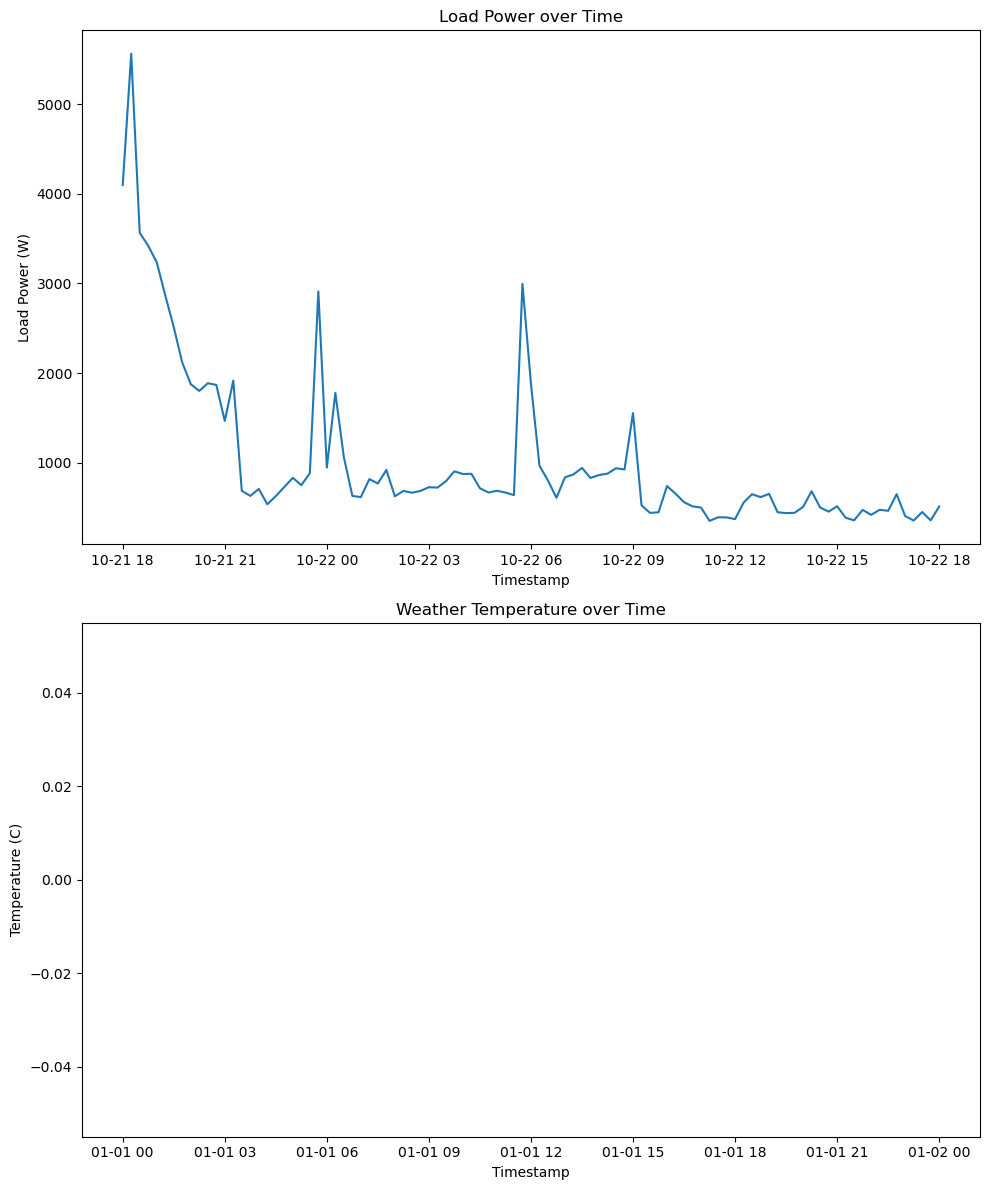

In [70]:
# plt.plot(np.arange(0,35039,1),df[df.customerID == 1].load_power_W)
# plt.figure(figsize=(10, 6))
# plt.plot(df['Date_UTC'][:97], df['load_power_W'][:97], linestyle='-')
# plt.title('Load Power over Time')
# plt.xlabel('Timestamp')
# plt.ylabel('Load Power (W)')
# plt.show()


fig, axs = plt.subplots(2, figsize=(10, 12))

# Plot for 'load_power_W'
axs[0].plot(df['Date_UTC'][:97], df['load_power_W'][:97], linestyle='-')
axs[0].set_title('Load Power over Time')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Load Power (W)')

# Plot for 'weather_Temp_C'
axs[1].plot(df['Date_UTC'][:97], df['weather_Temp_C'][:97], linestyle='-', color='r')
axs[1].set_title('Weather Temperature over Time')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Temperature (C)')

plt.tight_layout()
plt.show()

In [79]:
def day(num):
    return slice((num - 1) * 96, num * 96 + 1)

day(1)

slice(0, 97, None)

C:\Users\awikt\AppData\Local\Temp\ipykernel_24552\1331576943.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer['weather_Temp_C'] = scaler.fit_transform(df_customer[['weather_Temp_C']])


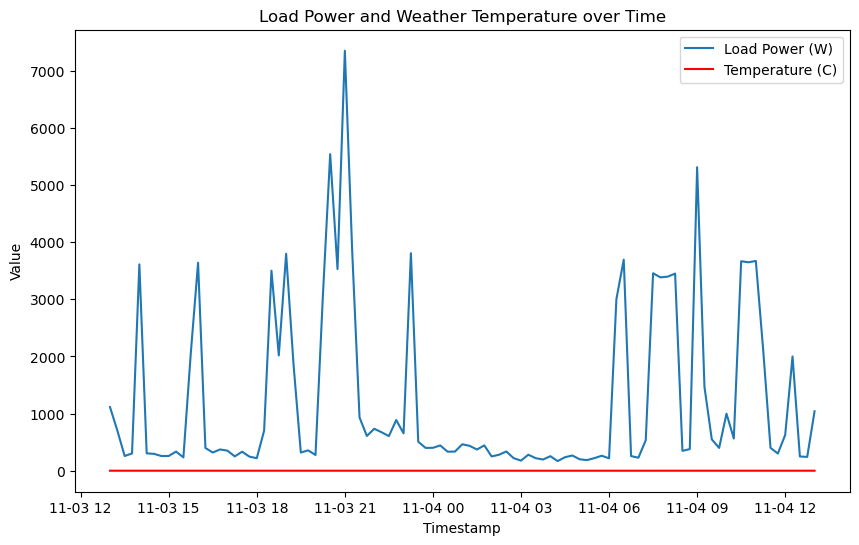

In [91]:
# def plot_customer_data(customer_id, day_num):
#     df_customer = df[df['customerID'] == customer_id]
#     # NORMALIZE DATA
#     print(df_customer)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['load_power_W'][day(day_num)], linestyle='-', label='Load Power (W)')
#     plt.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['weather_Temp_C'][day(day_num)], linestyle='-', color='r', label='Temperature (C)')
#     plt.title('Load Power and Weather Temperature over Time')
#     plt.xlabel('Timestamp')
#     plt.ylabel('Value')
#     plt.legend()
#     plt.show()
    
# plot_customer_data(850, 20)

def plot_customer_data(customer_id, day_num):
    df_customer = df[df['customerID'] == customer_id]
    
    # Normalize temperature data
    scaler = MinMaxScaler()
    df_customer['weather_Temp_C'] = scaler.fit_transform(df_customer[['weather_Temp_C']])
    
    plt.figure(figsize=(10, 6))
    plt.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['load_power_W'][day(day_num)], linestyle='-', label='Load Power (W)')
    plt.plot(df_customer['Date_NZDT'][day(day_num)], df_customer['weather_Temp_C'][day(day_num)], linestyle='-', color='r', label='Temperature (C)')
    plt.title('Load Power and Weather Temperature over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

plot_customer_data(850, 20)

In [61]:
print(type(df['Date_UTC'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
